# Titanic Classification Project

**Name:** Womenker Karto 
**Date:** 2025-11-10

**Introduction**

We predict passenger survival on the Titanic.  
We use the Titanic dataset.  
We train and compare classification models.  
We follow a clear pipeline: load, explore, prepare, model, compare, reflect.


In [12]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

import os
sns.set(style="whitegrid")


## 1. Import and Inspect the Data

### 1.1 Load the dataset and display the first 10 rows.

In [13]:
# Load dataset (seaborn) and save a project copy
df = sns.load_dataset("titanic")
os.makedirs("data", exist_ok=True)
df.to_csv("data/titanic.csv", index=False)

# Show first 10 rows
df.head(10)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


### 1.2 Check for missing values and summary statistics

**Reflection 1:**  
What do you notice about the dataset? Are there any data issues?

In [14]:
# Missing values and summary stats
print("Shape:", df.shape)
print("\nMissing values by column:\n", df.isnull().sum())

print("\nNumeric summary:")
display(df.describe(include=[np.number]).T)

print("\nCategorical summary:")
display(df.describe(include=['object','category']).T)


Shape: (891, 15)

Missing values by column:
 survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Numeric summary:


,count,mean,std,min,25%,50%,75%,max
survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292



Categorical summary:


,count,unique,top,freq
sex,891,2,male,577
embarked,889,3,S,644
class,891,3,Third,491
who,891,3,man,537
deck,203,7,C,59
embark_town,889,3,Southampton,644
alive,891,2,no,549


Reflection 1:

- `age` has many missing values and needs imputation.  
- `deck` has many missing values; drop it.  
- `embarked` has a few missing entries; fill with mode.  
- Some features are categorical and require encoding.

## 2. Data Exploration and Preparation

### 2.1 Explore data patterns and distributions

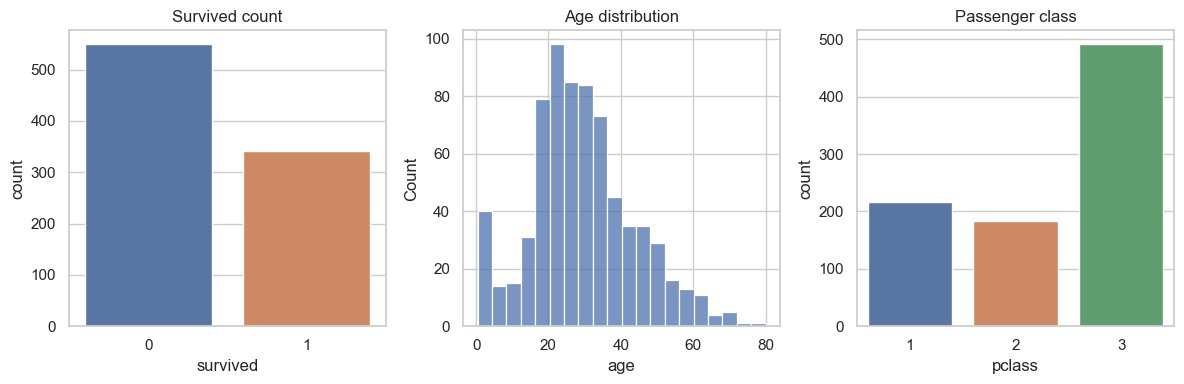

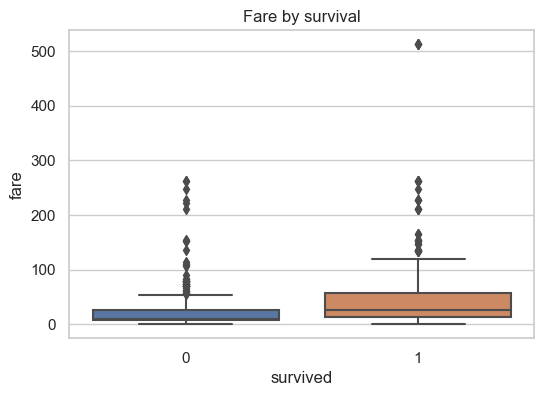

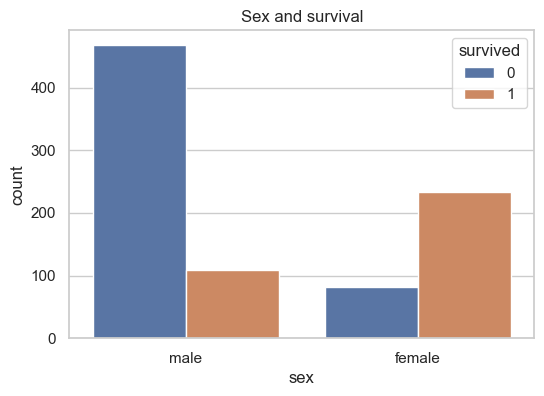

In [15]:
# Exploratory plots
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.countplot(x='survived', data=df)
plt.title('Survived count')

plt.subplot(1,3,2)
sns.histplot(df['age'].dropna(), bins=20)
plt.title('Age distribution')

plt.subplot(1,3,3)
sns.countplot(x='pclass', data=df)
plt.title('Passenger class')

plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='survived', y='fare', data=df)
plt.title('Fare by survival')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='sex', hue='survived', data=df)
plt.title('Sex and survival')
plt.show()

### 2.2 Handle missing values and clean data

We impute age. We fill embarked. We drop deck.

In [16]:
# Copy data and clean
data = df.copy()

# Impute age with median
data['age'] = data['age'].fillna(data['age'].median())

# Fill embarked with mode
data['embarked'] = data['embarked'].fillna(data['embarked'].mode()[0])

# Drop deck due to many missing values
if 'deck' in data.columns:
    data = data.drop(columns=['deck'])

# Confirm missing values
data.isnull().sum()

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
embark_town    2
alive          0
alone          0
dtype: int64

### 2.3 Feature selection and engineering

- Create `family_size` from `sibsp` + `parch` + 1.  
- One-hot encode categorical variables.  
- Scale numeric features in pipelines.

**Reflection 2:**  
What patterns or anomalies do you see? Do any features stand out? What preprocessing steps were necessary?

In [17]:
# Feature engineering
data['family_size'] = data['sibsp'] + data['parch'] + 1

# Features chosen
features = ['pclass', 'sex', 'age', 'fare', 'embarked', 'family_size']

# One-hot encode categorical features (drop_first to avoid multicollinearity)
data_model = pd.get_dummies(data[features], drop_first=True)

# Define X and y
X = data_model.copy()
y = data['survived'].copy()

print("Features used:", X.columns.tolist())
print("X shape:", X.shape, "y shape:", y.shape)

Features used: ['pclass', 'age', 'fare', 'family_size', 'sex_male', 'embarked_Q', 'embarked_S']
X shape: (891, 7) y shape: (891,)


Reflection 2:

- `sex` and `pclass` show strong differences by survival in plots.  
- `age` distribution has a long tail and some children.  
- `fare` has outliers; kept them but boxplot shows range differences.  
- Imputed `age` with median. Filled `embarked` with mode.  
- Created `family_size` to capture group effects.  
- Encoded categorical variables with one-hot encoding.

## 3. Feature Selection and Justification

### 3.1 Choose features and target

Selected features: `pclass`, `sex`, `age`, `fare`, `embarked`, `family_size`.  
Target: `survived`.

### 3.2 Define X and y

X and y defined above.

**Reflection 3:**  
Why did you choose these features? How might they impact predictions?

Reflection 3:

- `pclass` reflects socio-economic status and likely affects survival access.  
- `sex` historically influenced evacuation priority.  
- `age` captures vulnerability (children and elderly).  
- `fare` can proxy cabin location and class.  
- `family_size` captures group behavior and support.  
- `embarked` may reflect boarding location and class distribution.

These features are likely predictive of survival.

## 4. Train a Model (Logistic Regression)

### 4.1 Split the data into training and test sets.

In [18]:
# Split train and test with stratification on target
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (668, 7)
Test shape: (223, 7)


### 4.2 Train model using scikit-learn
We train a pipeline with scaling and Logistic Regression.

In [19]:
# Logistic Regression pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=200, random_state=42))
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=200, random_state=42))])

### 4.3 Evaluate performance

Compute accuracy, precision, recall, F1, ROC AUC, and confusion matrix.

**Reflection 4:**  
How well did the model perform? Any surprises?

In [20]:
# Evaluate logistic regression
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_proba)

print("Logistic Regression metrics:")
print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall: {rec:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"ROC AUC: {roc:.3f}\n")

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Logistic Regression metrics:
Accuracy: 0.771
Precision: 0.716
Recall: 0.674
F1-score: 0.695
ROC AUC: 0.836

Confusion Matrix:
[[114  23]
 [ 28  58]]

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       137
           1       0.72      0.67      0.69        86

    accuracy                           0.77       223
   macro avg       0.76      0.75      0.76       223
weighted avg       0.77      0.77      0.77       223



Reflection 4:

- The logistic model performs reasonably (accuracy around 0.77).  
- Precision and recall are moderate.  
- `sex` and `pclass` drive most of the signal.  
- No large surprises. Missing age required imputation but did not break model.

## 5. Improve the Model or Try Alternates

### 5.1 Train an alternative classifier (Random Forest)

In [21]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:,1]

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_rf = roc_auc_score(y_test, y_proba_rf)

print("Random Forest metrics:")
print(f"Accuracy: {acc_rf:.3f}")
print(f"Precision: {prec_rf:.3f}")
print(f"Recall: {rec_rf:.3f}")
print(f"F1-score: {f1_rf:.3f}")
print(f"ROC AUC: {roc_rf:.3f}\n")

print("Confusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

Random Forest metrics:
Accuracy: 0.771
Precision: 0.733
Recall: 0.640
F1-score: 0.683
ROC AUC: 0.829

Confusion Matrix (Random Forest):
[[117  20]
 [ 31  55]]

Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       137
           1       0.73      0.64      0.68        86

    accuracy                           0.77       223
   macro avg       0.76      0.75      0.75       223
weighted avg       0.77      0.77      0.77       223



### 5.2 Compare performance of all models

Plot ROC curves for both models.

**Reflection 5:**  
Which model performed better? Why might one classifier be more effective?

Comparison summary:
Logistic Accuracy: 0.771, RF Accuracy: 0.771
Logistic F1: 0.695, RF F1: 0.683
Logistic ROC AUC: 0.836, RF ROC AUC: 0.829


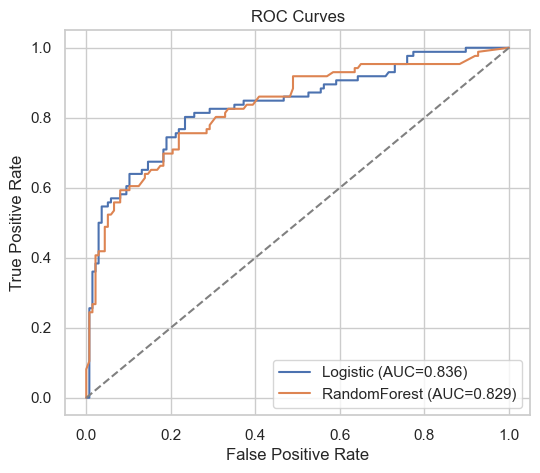

In [22]:
# Comparison summary
print("Comparison summary:")
print(f"Logistic Accuracy: {acc:.3f}, RF Accuracy: {acc_rf:.3f}")
print(f"Logistic F1: {f1:.3f}, RF F1: {f1_rf:.3f}")
print(f"Logistic ROC AUC: {roc:.3f}, RF ROC AUC: {roc_rf:.3f}")

# ROC curves plot
fpr_l, tpr_l, _ = roc_curve(y_test, y_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(6,5))
plt.plot(fpr_l, tpr_l, label=f'Logistic (AUC={roc:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={roc_rf:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

Reflection 5:

Both **Logistic Regression** and **Random Forest** achieved similar overall accuracy (0.771).  
However, **Logistic Regression** slightly outperformed Random Forest in **F1-score (0.695 vs 0.683)** and **ROC AUC (0.836 vs 0.829)**, indicating better balance between precision and recall.  
Thus, for this dataset, **Logistic Regression** was slightly more effective and interpretable, while Random Forest did not provide a notable improvement.  


## 6. Final Thoughts & Insights

### 6.1 Summarize findings
### 6.2 Discuss challenges faced
### 6.3 If you had more time, what would you try next?

**Reflection 6:** What did you learn from this project?

Final summary:

- Both models give useful predictions.  
- `sex` and `pclass` are the most predictive features.  
- Imputing `age` and adding `family_size` helped performance.

Challenges:

- Missing values in `age`.  
- Limited feature richness in the dataset.

If more time:

- Run GridSearchCV for hyperparameter tuning.  
- Use repeated cross-validation for more stable estimates.  
- Add feature interactions and try boosted trees (XGBoost).  
- Visualize feature importances and SHAP values for explainability.
